# Tweets Classification for recommendation engine  

### Introduction

The goal of this work is to build predictive models that can automatically infer people’s needs from user- generated content. Specifically, we want to analyze text data from social media in order to build a recommender system. The engine can be able to recognize a specific need or pattern inside the data and suggest a product to sell. For example, we suppose to analyze data from twitter and try to identify people who want to travel in the future (or who are a "traveller") and suggest them a travel-related products. 

### Training set construction

One of the main issues in NLP problems like this is that we not have a collection of labelled examples as training set. That’s why data labeling is usually the bottleneck in developing NLP applications and keeping them up-to-date. Can be very hard to labelling a lot of tweets and the training step require a  thousands of labeled examples. Also we have to decide how extract the data from the social source in order to create a dataset that can be a "true" representation of a real context. 

We start by define a set of heuristic rule to use in the Twitter API to obtain the data. We use for example the high level descriptions of travel-correleted products to extract an array of keywords that can be associated to the "traveller world". We use this list of words combined with other specific patterns (or regular expressions) to build a set of rules. By using the Twitter API we extract some thousands of tweets travel-related and other tweet that can be labelled as "general" because extracted with no rules. 

Using this data we can try to build a classifier by combining weak supervision and data augmentation/pseudo labelling techniques. We follow this 4 step:
* collect a small number of manual labeled examples;
* use the back translation as data augmentation technique to increse the number of labeled example in the training set;
* build a weak binary classifier using the basic ML models (Multinomial Naïve Bayes and Logistic Regression);
* classify the data in the unlabeled set and repeat the process to improve the performance.

<img src="img/training_construction.png" height="700" width="800">

### Import the data

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
training = pd.read_csv("data/training_travel.csv", index_col=0)

In [4]:
training.head()

,index,text,label
1897,15028,did scomo really just get a ‘lifeline bounce’ ...,general
1106,31355,shit tastes like GARBAGE but the trip? beautif...,general_travel
342,29098,Winter comes in many guises in Europe – in the...,travel
1926,4446,so uk is leaving eu by end of march by default...,general
28,37269,We shall be going! Adventure Travel Show retur...,travel


In [5]:
training.shape

(1986, 3)

As we can see, in this training set we have tweets labeled as "general" and other labeled as "general travel". This is due by the fact that we have some tweets in our training set that are releted to the topics "travel" but are not what we are searching.
For example, some people can write about the journey of someone else, a third part like some friend or a famous person.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

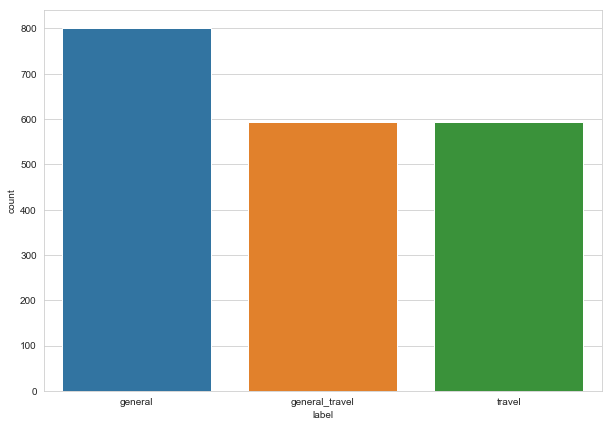

In [7]:
plt.figure(figsize=(10,7))
sns.countplot(data=training, x='label')
plt.show()

### Text Cleaning and pre-processing

For the first model we cleaned the text by removing all the special character and stopwords. Also, we extract the lemma of each tokens in the text. 

In [8]:
from mltools.textMining import TextPreprocessing

In [9]:
tp = TextPreprocessing(lemmatization = True, remove_stopwords=True)

In [10]:
import joblib
joblib.dump(tp, 'tp_travel.pkl')

['tp_travel.pkl']

In [10]:
%time training_clean = tp.fit(training, "text", min_len=2)

Data cleaning...
Standardization...
Tokenization...
Removing stopwords...
Lemmatization...
Finish
CPU times: user 25min 1s, sys: 3min 36s, total: 28min 38s
Wall time: 28min 26s


In [11]:
training_clean.head()

,index,text,label,tokens,lemma
1897,15028,did scomo really just get a lifeline bounce ...,general,"[scomo, really, get, lifeline, bounce, polls, ...","[scomo, really, get, lifeline, bounce, poll, a..."
1106,31355,shit tastes like garbage but the trip beautif...,general_travel,"[shit, tastes, like, garbage, trip, beautiful,...","[shit, taste, like, garbage, trip, beautiful, ..."
342,29098,winter comes in many guises in europe in the...,travel,"[winter, comes, many, guises, europe, north, s...","[winter, come, many, guise, europe, north, ser..."
1926,4446,so uk is leaving eu by end of march by default...,general,"[leaving, end, march, default, settings, curio...","[leave, end, march, default, setting, curious,..."
28,37269,we shall be going adventure travel show retur...,travel,"[shall, going, adventure, travel, show, return...","[shall, go, adventure, travel, show, return, o..."


### Train/Test (validation set or Held-out set) split

Before starting with oversample techniques and feature extraction, is important to split the training data into two sample: one for select the best model configuration and one (the held-out) for the performance evaluation. In this case we use the 80% of our data for training and the 20% for the validation. 

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(training_clean, training_clean["label"], 
                                                    test_size=0.2, 
                                                    random_state=40)

In [14]:
print(X_train.shape, X_test.shape)

(1588, 5) (398, 5)


### Renaming the classes 

In [15]:
def rename_class(label):
    if label == 'general_travel':
        return 'general'
    else:
        return label

In [16]:
X_train['label'] = X_train['label'].apply(rename_class)
X_test['label'] = X_test['label'].apply(rename_class)

In [17]:
y_train = y_train.apply(rename_class)
y_test = y_test.apply(rename_class)

In [18]:
y_train.value_counts()

general    1120
travel      468
Name: label, dtype: int64

In [19]:
y_test.value_counts()

general    273
travel     125
Name: label, dtype: int64

### Fitting a classifier using the augmented training set  

When the class in our training set are unbalanced, in order to improve the performance of our classifier, it's a good choice to resample the minority class. For do this, we try to apply a data augmentation techniques. 
An effective method is to augment the training corpus with back-translations of target language sentences. In this case we use a very simplified version of this method and we select a two random samples of example and back translated these senteces in two different languages.
Then we add these syntethic example to our training set.

In [20]:
new_examples = pd.read_csv("data/training_travel_bt_1_en_zh-tw.csv", index_col=False)

In [21]:
new_examples = new_examples[['index', 'text', 'label']].dropna()

In [22]:
%time new_examples = tp.fit(new_examples, "text", min_len=1)

Data cleaning...
Standardization...
Tokenization...
Removing stopwords...
Lemmatization...
Finish
CPU times: user 3min, sys: 25.8 s, total: 3min 26s
Wall time: 1min 29s


In [23]:
X_train_augmented = pd.concat([X_train, new_examples])

In [24]:
new_examples = pd.read_csv("data/training_travel_bt_1_en_he.csv", index_col=False)
new_examples = new_examples[['index', 'text', 'label']].dropna()
%time new_examples = tp.fit(new_examples, "text", min_len=1)

Data cleaning...
Standardization...
Tokenization...
Removing stopwords...
Lemmatization...
Finish
CPU times: user 3min 15s, sys: 28.2 s, total: 3min 44s
Wall time: 1min 36s


In [25]:
X_train_augmented = pd.concat([X_train_augmented, new_examples])

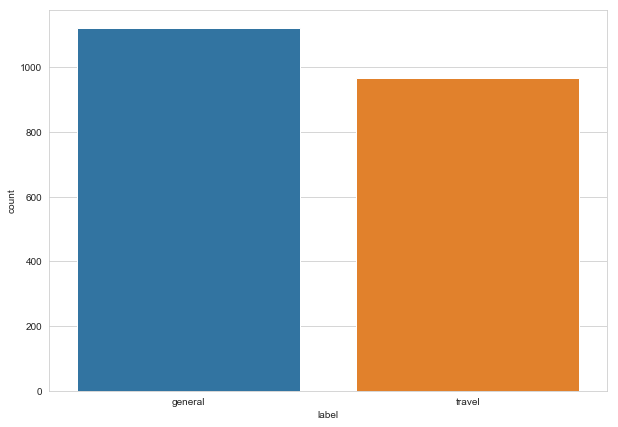

In [26]:
plt.figure(figsize=(10,7))
sns.countplot(data=X_train_augmented, x='label')
plt.show()

### Text Vectorization 

Now we want to obtain the features matrix. For our simple first model we want to use a Bag of Words representation, coding each lemma by using the TF-IDF.

In [27]:
from mltools.textMining.text_preprocessing import VectorizeData

In [28]:
token_toVect = VectorizeData(method='tf-idf')
train, test, vectorizer = token_toVect.fit(X_train_augmented["lemma"], X_test["lemma"])

In [29]:
from sklearn.preprocessing import LabelEncoder

In [30]:
lb = LabelEncoder()
y_train = lb.fit_transform(X_train_augmented['label'])

### Fittig a ML model using k-fold cross validation 

Now we can try to fit a ML model to predict the label of the given tweet using the Bag Of Word sparse matrix and TF-IDF. We test a Multinomial Naïve Bayes and a Logistic Regression on 10-fold cross validation. The best parameters configuration was obtained using a grid search and the F1 measure as loss function to maximize. 

In [31]:
from mltools.evaluateModels import CrossValidation

In [32]:
cv = CrossValidation(models=["MultinomialNB", "LogisticRegression"], 
                     scores = ["auc", "mcc", "f1", "recall", "precision"],
                     params_file = "./param_file.txt")

In [33]:
%time res, model = cv.fit_cv(train, y_train)

Model: MultinomialNB
Searching the best MultinomialNB with grid search cv...

Best_estimator: MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

Best_scores: 0.7994459351963976
Evaluate the best model configuration with a new cross validation...

Model: LogisticRegression
Searching the best LogisticRegression with grid search cv...

Best_estimator: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Best_scores: 0.8154035194373602
Evaluate the best model configuration with a new cross validation...

Finish
CPU times: user 806 ms, sys: 130 ms, total: 937 ms
Wall time: 1.23 s


In [34]:
res

,LogisticRegression,MultinomialNB
computation_total,0.0542715,0.0378113
test_auc_mean,0.835612,0.801748
test_auc_sd,0.0630007,0.0642807
test_auc_ci_95%,"[0.8206, 0.8506]","[0.7864, 0.8171]"
test_auc_ci_99%,"[0.814, 0.8572]","[0.7797, 0.8238]"
train_auc_mean,0.937644,0.978924
train_auc_sd,0.00383383,0.00182915
train_auc_ci_95%,"[0.9367, 0.9386]","[0.9785, 0.9794]"
train_auc_ci_99%,"[0.9363, 0.939]","[0.9783, 0.9796]"
test_mcc_mean,0.677811,0.613374


### Evaluate the Logistic model on held-out set

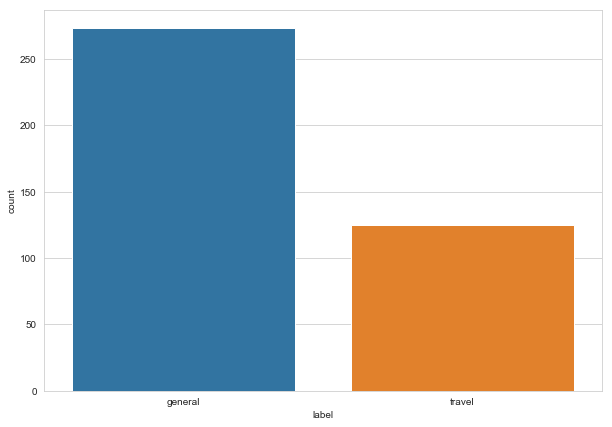

In [35]:
plt.figure(figsize=(10,7))
sns.countplot(data=X_test, x='label')
plt.show()

In [36]:
y_test = lb.fit_transform(y_test)

In [37]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, matthews_corrcoef

lr = model['LogisticRegression']
y_predicted = lr.predict(test)

print("F1 Logistic Regression on test set:", f1_score(y_test, y_predicted))
print("AUC Logistic Regression on test set:", roc_auc_score(y_test, y_predicted))
print("MCC Logistic Regression on test set:", matthews_corrcoef(y_test, y_predicted))
print("Precision Logistic Regression on test set:", precision_score(y_test, y_predicted))

F1 Logistic Regression su test set: 0.7426470588235294
AUC Logistic Regression su test set: 0.8197509157509157
MCC Logistic Regression su test set: 0.6150105906714609
Precision Logistic Regression su test set: 0.6870748299319728


### Evaluate the confidence of the model 

As we can see above, using this simple approach and a Logistic Regression model, we are able to obtain a good result (0.74 of f1 score). Now it's time to understand if the behavior of the model is correct. For do this, we can analyze the confidence of the model (calculated as the difference of the probabilities for each of the two class) and the features importance. 

In [38]:
prob = lr.predict_proba(train)

In [39]:
confidence_score = prob[:,1] - prob[:,0]

In [40]:
df = X_train_augmented.copy()
df['score'] = confidence_score

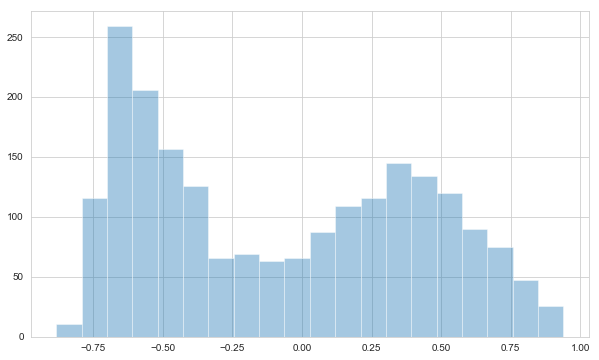

In [41]:
plt.figure(figsize=(10,6))
sns.distplot(confidence_score, kde=False, bins=20)

From the distribution plot above, it's clear that the model are not much "confident" to assing the label 1 (travel, suggest the item). We have a lot of examples in a zone of uncertainty. If we analyze the distribution in the validation set (that are more unbalanced) we observe that the uncertainty of our model is high. 

In [42]:
prob = lr.predict_proba(test)

In [43]:
confidence_score = prob[:,1] - prob[:,0]

In [44]:
df = X_test.copy()
df['score'] = confidence_score
df['label_predicted'] = y_predicted

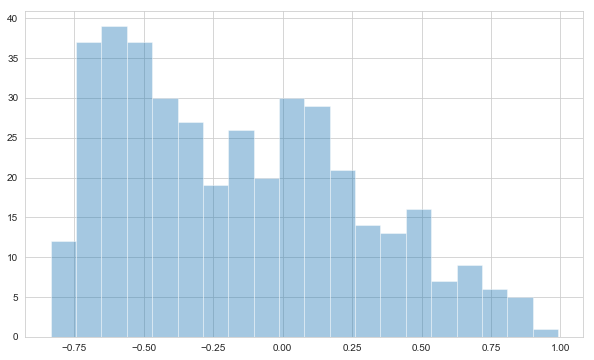

In [45]:
plt.figure(figsize=(10,6))
sns.distplot(confidence_score, kde=False, bins=20)

### Feature Importance 

The features importance show us that the model takes as important features some reasonable words and others that probabily come from some bias inside the data used for the training (for example "disney" or "japan"). So, starting from this Logistic regression model, we want to improve the strength of our algorithm. 

In [46]:
from mltools.textMining import *

In [47]:
importance = get_most_important_features(vectorizer, lr, n=20)
importance

{0: {'bottom': [(-0.7362261004274654, 'party'),
   (-0.7413033131001128, 'okay'),
   (-0.7466894511714356, 'could'),
   (-0.7765496522319587, 'safe'),
   (-0.7971402549667075, 'literally'),
   (-0.7999117812356316, 'someone'),
   (-0.805524624118541, 'eat'),
   (-0.8210619103066288, 'president'),
   (-0.8261008891650106, 'game'),
   (-0.8377570140314986, 'smile'),
   (-0.8538097197224855, 'amp'),
   (-0.8686134335368486, 'run'),
   (-0.8790230767614244, 'group'),
   (-0.8805683790151752, 'show'),
   (-0.8842649489147846, 'people'),
   (-0.9727614475107754, 'trump'),
   (-0.9783424966100328, 'kid'),
   (-1.0062252313696267, 'help'),
   (-1.0159630023461117, 'read'),
   (-1.246413228665031, 'way')],
  'tops': [(1.3488328281834518, 'need'),
   (1.3667854544867504, 'love'),
   (1.3683216650425765, 'flight'),
   (1.417700065269185, 'disney'),
   (1.4671663809326094, 'thank'),
   (1.4857021969119637, 'planning'),
   (1.5034427945671383, 'visit'),
   (1.532111177627194, 'plane'),
   (1.541287

# Pseudo-Labelling

In order to apply any supervised learning algorithm we need more data to build a robust model. To solve these type of problems, we define a different type of learning known as semi-supervised learning, which is used both labelled data (supervised learning) and unlabelled data (unsupervised learning). In pseudo-labelling, instead of manually labeling the unlabelled data, we give approximate labels on the basis of the labelled data. Adding unlabelled data, the decision boundary of our model has become more accurate.

<img src="img/pseudo_labelling.png" height="500" width="500">

Due to the computational cost of the lemmatization step, we have previously extract a sample of 80k examples (for 40k the lemmatization take about 8 hours on MacBook Pro with Intel i9):

In [48]:
unlabeled_data_1 = pd.read_csv('data/unlabeled_lemma_40k.csv', index_col=0)
unlabeled_data_2 = pd.read_csv('data/unlabeled_lemma_40k_2.csv', index_col=0)

In [49]:
unlabeled_data = pd.concat([unlabeled_data_1, unlabeled_data_2])

In [50]:
feature_matrix  = vectorizer.transform(unlabeled_data["lemma"].apply(str))

In [51]:
prob = lr.predict_proba(feature_matrix)

In [52]:
unlabeled_data['confidence_score'] = prob[:,1] - prob[:,0]

### Extract a new sample for training 

In order to reduce the noise inside the training set, we sample only the examples that have a confidence score greater than 0.5 (in this way we are sure to increase the precision of our model). 

In [53]:
travel_sample = unlabeled_data[unlabeled_data['confidence_score'] > 0.5]

In [54]:
travel_sample.shape

(2723, 5)

In [55]:
travel_sample.head()

,index,text,tokens,lemma,confidence_score
16161,105197,i d love to make that trip again,"['love', 'make', 'trip']","['love', 'make', 'trip']",0.910023
5148,14864,i just realized i m gonna be traveling to new ...,"['realized', 'gonna', 'traveling', 'new', 'pla...","['realize', 'go', 'to', 'travel', 'new', 'plac...",0.858341
3276,89145,foolish heroes my true plan is for the next w...,"['foolish', 'heroes', 'true', 'plan', 'next', ...","['foolish', 'hero', 'true', 'plan', 'next', 'w...",0.662962
15531,38623,makes sense i m in denver international twic...,"['makes', 'sense', 'denver', 'international', ...","['make', 'sense', 'denver', 'international', '...",0.670047
35240,63770,went on a road trip with a friend who is...,"['went', 'road', 'trip', 'friend', 'white', 'm...","['go', 'road', 'trip', 'friend', 'white', 'mal...",0.627472


In [56]:
travel_sample['text'].iloc[3]

' makes sense  i m in denver international twice a year and i never seem to have the time to make sure i see them  but i had some time to spare this trip  i only found two  hoping to see the third next time '

In [57]:
general_sample = unlabeled_data[unlabeled_data['confidence_score'] < -0.6]

# Fitting a new model using the new labelled data

### Cleaning the training data

For reduce again the noise inside the data, we can apply some heuristic rules: for example is possible that one of the most predictive features, the word "trip", can be associated to the consuming of drugs. We want to remove this row from our training set. 

In [58]:
import regex as re

In [59]:
rules = r"\b(acid trip|drug trip|mental trip|no money)"

def find_false_positive(tweet_text):
    return True if re.search(rules, tweet_text) else False

In [60]:
travel_sample['to_drop'] = travel_sample['text'].apply(find_false_positive)

In [61]:
travel_sample[travel_sample['to_drop']].shape

(6, 6)

In [62]:
travel_sample[travel_sample['to_drop']].head()

,index,text,tokens,lemma,confidence_score,to_drop
15542,60508,like last week pretty sure this was not an ac...,"['like', 'last', 'week', 'pretty', 'sure', 'ac...","['like', 'last', 'week', 'pretty', 'sure', 'ac...",0.567234,True
13162,38700,i love to go but i have no money to travel ...,"['love', 'money', 'travel', 'far']","['love', 'money', 'travel', 'far']",0.620155,True
1763,52552,i ve had an acid trip like that,"['acid', 'trip', 'like']","['acid', 'trip', 'like']",0.926982,True
7850,58784,it s like a mini acid trip for a sec there,"['like', 'mini', 'acid', 'trip', 'sec']","['like', 'mini', 'acid', 'trip', 'sec']",0.521310,True
37261,54995,i will and in the meantime it s like i m on a...,"['meantime', 'like', 'acid', 'trip', 'somethin...","['meantime', 'like', 'acid', 'trip', 'somethin...",0.541764,True


In [63]:
travel_sample = travel_sample[travel_sample['to_drop'] == False]

In [64]:
max_len = 4

def find_short_tweets(tweet_text):
    return True if len(tweet_text.split(" "))<= max_len else False

In [65]:
travel_sample['too_short'] = travel_sample['text'].apply(find_false_positive)

In [66]:
travel_sample[travel_sample['too_short']].shape

(0, 7)

In [67]:
df_travel = travel_sample[['index', 'text', 'tokens', 'lemma']]
df_travel['label'] = 'travel'

In [68]:
df_general = general_sample[['index', 'text', 'tokens', 'lemma']]
df_general['label'] = 'general'

In [69]:
pseudolabel_training = pd.concat([df_general.sample(n=3000, random_state=123), df_travel])

### Building the final model 

In [70]:
new_test = X_train_augmented.sample(n=400, random_state=123)

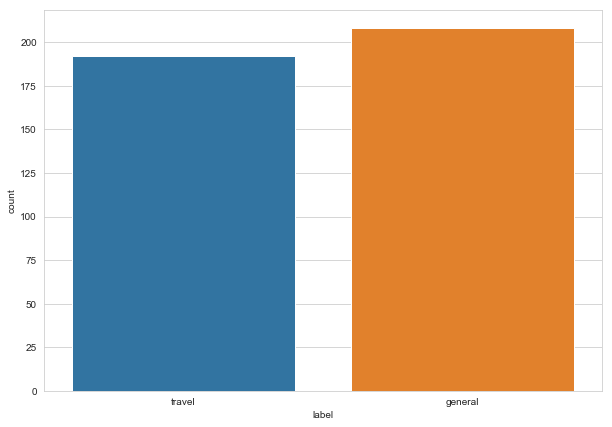

In [71]:
plt.figure(figsize=(10,7))
sns.countplot(data=new_test, x='label')
plt.show()

In [72]:
training = pd.concat([X_train_augmented[~X_train_augmented['index'].isin(new_test['index'])], X_test])

In [73]:
pseudolabel_training.head()

,index,text,tokens,lemma,label
10332,11884,why people think prince philip amp s car c...,"['people', 'think', 'prince', 'philip', 'amp',...","['people', 'think', 'prince', 'philip', 'amp',...",general
36522,42055,agency orange county sheriff s department cal...,"['agency', 'orange', 'county', 'sheriff', 'dep...","['agency', 'orange', 'county', 'sheriff', 'dep...",general
3988,4577,lost my husband in car crash then my job a...,"['lost', 'husband', 'car', 'crash', 'job', 'am...","['lose', 'husband', 'car', 'crash', 'job', 'am...",general
28752,33109,i near i shut down in both directions a...,"['near', 'shut', 'directions', 'multi', 'vehic...","['near', 'shut', 'direction', 'multi', 'vehicl...",general
26960,31059,my goodness labour s richard burgon has given...,"['goodness', 'labour', 'richard', 'burgon', 'g...","['goodness', 'labour', 'richard', 'burgon', 'g...",general


In [74]:
all_data = pd.concat([training, pseudolabel_training])

In [75]:
all_data.shape

(7585, 5)

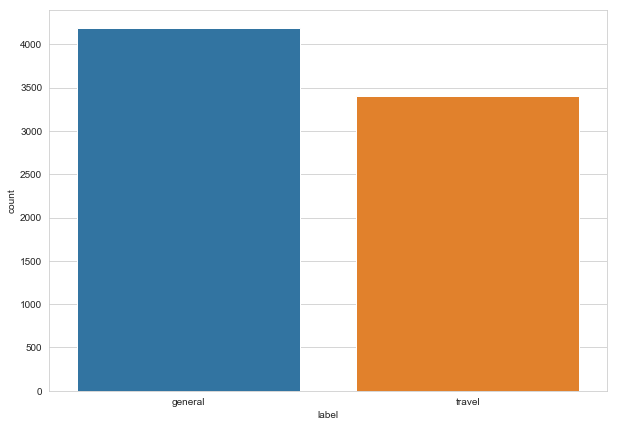

In [76]:
plt.figure(figsize=(10,7))
sns.countplot(data=all_data, x='label')
plt.show()

### Evaluate different Features set

For this final task, we want to analyze different feature set in addition to the BoW representation after the lemmatization step. We consider a binary representation of the tokens extracted (including the stopwords) and the skip gram matrix. 

In [77]:
tp = TextPreprocessing(lemmatization = False, remove_stopwords=False)

In [78]:
%time all_data = tp.fit(all_data, "text", min_len=2)

Data cleaning...
Standardization...
Tokenization...
Finish
CPU times: user 153 ms, sys: 3.55 ms, total: 156 ms
Wall time: 155 ms


In [79]:
import functools
from nltk.util import skipgrams 

In [80]:
skipper = functools.partial(skipgrams, n=2, k=2) 

In [81]:
token_toVect = VectorizeData(method='binary')
train_gram, vectorizer_gram = token_toVect.fit(all_data["tokens"], skipper=skipper)

In [82]:
token_toVect = VectorizeData(method='tf-idf')
train_tokens, vectorizer_tokens = token_toVect.fit(all_data["tokens"])

In [83]:
train_lemma, vectorizer_lemma = token_toVect.fit(all_data["lemma"])

In [84]:
print(train_lemma.shape, train_tokens.shape, train_gram.shape)

(7585, 12381) (7585, 14786) (7585, 60000)


In [85]:
feature_set = { 'lemma': train_lemma,
                'tokens': train_tokens,
                'gramk2': train_gram
}

In [86]:
lb = LabelEncoder()
y_train = lb.fit_transform(all_data['label'])

In [87]:
cv = CrossValidation(models=["LogisticRegression"], 
                     scores = ["auc", "mcc", "f1", "recall", "precision"],
                     params_file = "./param_file.txt")

In [88]:
models_dict = {}

In [89]:
%%time 

for key, value in feature_set.items():
    print("START WITH: \n{}".format(key))
    res, model = cv.fit_cv(value, y_train)
    models_dict[key] = model
    res.to_csv('results/{}.csv'.format(key))

START WITH: 
lemma
Model: LogisticRegression
Searching the best LogisticRegression with grid search cv...

Best_estimator: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Best_scores: 0.9519744242103475
Evaluate the best model configuration with a new cross validation...

Finish
START WITH: 
tokens
Model: LogisticRegression
Searching the best LogisticRegression with grid search cv...

Best_estimator: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Best_scores: 0.9509264347296913
Evaluate the best model configuration with a new cross validation...

Finish
START W

### Conclusion and final evaluation 

In [90]:
y_test = lb.fit_transform(new_test['label'])

In [91]:
x_test  = vectorizer_lemma.transform(new_test["lemma"].apply(str))

In [92]:
lr = models_dict['lemma']['LogisticRegression']
y_predicted = lr.predict(x_test)

print("F1 Logistic Regression on test set:", f1_score(y_test, y_predicted))
print("AUC Logistic Regression on test set:", roc_auc_score(y_test, y_predicted))
print("MCC Logistic Regression on test set:", matthews_corrcoef(y_test, y_predicted))
print("Precision Logistic Regression on test set:", precision_score(y_test, y_predicted))

F1 Logistic Regression on test set: 0.7979539641943735
AUC Logistic Regression on test set: 0.8028846153846154
MCC Logistic Regression on test set: 0.6052919875803631
Precision Logistic Regression on test set: 0.7839195979899497


By using the model fitted on the original training set with the pseudo-labeled set, we can see that we have an improvement of about 10% in our scores. Also, the confidence of our model seems better. 

In [93]:
prob = lr.predict_proba(x_test)

In [94]:
confidence_score = prob[:,1] - prob[:,0]

In [95]:
df = new_test.copy()
df['score'] = confidence_score
df['label_predicted'] = y_predicted

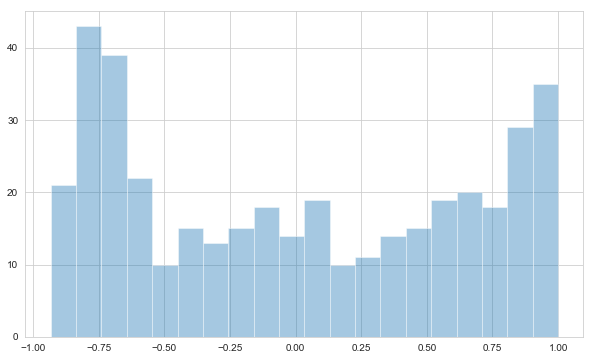

In [96]:
plt.figure(figsize=(10,6))
sns.distplot(confidence_score, kde=False, bins=20)
plt.show()

Even the most predictive features are better:

In [97]:
importance = get_most_important_features(vectorizer_lemma, lr, n=20)
importance

{0: {'bottom': [(-1.2633272479328221, 'school'),
   (-1.264364815413947, 'truck'),
   (-1.281964904665663, 'game'),
   (-1.3025146373400616, 'woman'),
   (-1.3283092450986669, 'bad'),
   (-1.341768673556547, 'driver'),
   (-1.4172654330189658, 'run'),
   (-1.4373490317635977, 'trump'),
   (-1.4849473454662827, 'kid'),
   (-1.4912839979661814, 'show'),
   (-1.550973561597181, 'way'),
   (-1.5964932308040678, 'say'),
   (-1.642219538334741, 'die'),
   (-1.8538739291344188, 'people'),
   (-1.917537093925974, 'amp'),
   (-2.297227887010879, 'hit'),
   (-2.425206161276598, 'vehicle'),
   (-2.5111520708793957, 'break'),
   (-4.47546734486943, 'crash'),
   (-5.939859062069736, 'car')],
  'tops': [(2.076837051358658, 'month'),
   (2.1241817365653644, 'weekend'),
   (2.1243683016313306, 'world'),
   (2.1277694757142616, 'to'),
   (2.1724824249054846, 'day'),
   (2.261428729804724, 'thank'),
   (2.2990351652562984, 'city'),
   (2.347565400425259, 'tomorrow'),
   (2.409571583380099, 'need'),
   (

The precision of the final model can also be increase by changing the decision threshold. Obviously, if you want to increase the precision you have to reduce the recall. The final configuration can be set using the business knowledge of our specific problem.

In [116]:
def my_prediction(score):
    if score > 0.5:
        return 1
    else:
        return 0

In [117]:
my_pred = df['score'].apply(my_prediction)

In [118]:
print("F1 Logistic Regression on test set:", f1_score(y_test, my_pred))
print("AUC Logistic Regression on test set:", roc_auc_score(y_test, my_pred))
print("MCC Logistic Regression on test set:", matthews_corrcoef(y_test, my_pred))
print("Precision Logistic Regression on test set:", precision_score(y_test, my_pred))

F1 Logistic Regression on test set: 0.6645367412140575
AUC Logistic Regression on test set: 0.7299679487179486
MCC Logistic Regression on test set: 0.5002473562177442
Precision Logistic Regression on test set: 0.859504132231405


### Saving the final model 

In [105]:
joblib.dump(vectorizer_lemma, 'vectorizer.pkl')

['vectorizer.pkl']

In [106]:
joblib.dump(lr, 'logistic_regression.pkl')

['logistic_regression.pkl']

# Next steps and possibles improvements

### Use large pre-trained language model for transfer learning 

Transfer Learning has greatly impacted computer vision. Using a pre-trained ConvNet on ImageNet as initialization or fine-tuning it to your task at hand has become very common. In NLP we have some neural model pre-trained like ULMFiT. This model provides a Universal Language Model, pre-trained on millions of Wikipedia pages, which we can fine-tune to our specific domain space. Then, we can train a text classification model that leverages the LM’s learned text representations which can learn with very few examples (up to 100x less data).
The advantages are that with linguistic model like that it's possible to modelize the semantic of the text and better understand the meaning of the content. 

### Create a recommendation engine for more than one product category

Using this kind of approach it's simple to imagine a "bigger" engine that can be use to indentify more needs/topics inside the social data and suggest more than one kind of product/item, supporting also a mulitlabelling classification. In fact, if we suppose to create for each of these label a specific binary classifier, each of then trained on a specific domain, is simple to collect all of these models inside an high level "Black Box". This approach is like a stacking of ML models and the finals recommendation rules can be obtain by apply a new super-learner model or bussiness logic rules on the predicted probabilities.

<img src="img/stack_model.png" height="700" width="800">